In [1]:
import numpy as np

from scipy.fft import fft, ifft, fftfreq
from scipy.io import wavfile
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
duration = 2.0 # длина сэмпла секунд
sample_rate = 8000 # частота дискретизации Гц
n_samples = 2 ** int(np.ceil(np.log2(sample_rate * duration)))  # длина - как двойка в степени

duration = n_samples/sample_rate
print(f"Длина лупа = {duration} c")

Длина лупа = 2.048 c


In [3]:
def make_white_noise(n_samples):
    noise = np.random.normal(0, 1, n_samples)
    return noise - np.mean(noise)


def check_gaussian(signal):
    stat, p = shapiro(signal[:5000])
    print(f'Статистика={stat:.3f}, p-значение={p:.3f}')
    if p > 0.05:
        print('Кажись, распределение норм.')
    else:
        print('Кажись, распределение не норм.')

def lowpass_filter(signal, cutoff_freq=100, sample_rate=8000, transition_band=5):
    # Применяем FFT к сигналу
    freq_signal = fft(signal)
    frequencies = fftfreq(len(signal), 1 / sample_rate)

    # Создаем оконную функцию для НЧ-фильтра
    window = np.ones_like(frequencies)
    
    # Определяем частоты выше частоты среза + переходная зона
    transition_start = cutoff_freq
    transition_end = cutoff_freq + transition_band

    # Обнуляем частоты выше transition_end
    window[np.abs(frequencies) >= transition_end] = 0

    # Применяем косинусное затухание в переходной зоне
    transition_zone = (np.abs(frequencies) >= transition_start) & (np.abs(frequencies) < transition_end)
    window[transition_zone] = 0.5 * (1 + np.cos(np.pi * (np.abs(frequencies[transition_zone]) - transition_start) / transition_band))

    # Применяем окно к спектру сигнала
    filtered_freq_signal = freq_signal * window

    # Обратное FFT для получения отфильтрованного сигнала
    filtered_signal = np.real(ifft(filtered_freq_signal))
    return filtered_signal

def create_frequency_window(frequencies, low_freq, high_freq, transition_band):
    # Инициализируем нулевой массив окна
    window = np.zeros_like(frequencies)

    # Определяем полосы частот
    pass_band = (np.abs(frequencies) >= low_freq) & (np.abs(frequencies) <= high_freq)
    transition_low = (np.abs(frequencies) > low_freq - transition_band) & (np.abs(frequencies) < low_freq)
    transition_high = (np.abs(frequencies) > high_freq) & (np.abs(frequencies) < high_freq + transition_band)

    # Полоса пропускания
    window[pass_band] = 1

    # Переходная зона низких частот
    window[transition_low] = 0.5 * (1 + np.cos(np.pi * (np.abs(frequencies[transition_low]) - low_freq + transition_band) / transition_band))

    # Переходная зона высоких частот
    window[transition_high] = 0.5 * (1 + np.cos(np.pi * (np.abs(frequencies[transition_high]) - high_freq) / transition_band))

    return window



def bandpass_filter_with_window(signal, low_freq=100, high_freq=640, sample_rate=8000, transition_band=5):
    if low_freq == 0:
        return lowpass_filter(signal, high_freq, sample_rate, transition_band)

    # Применяем FFT
    freq_signal = fft(signal)
    frequencies = fftfreq(len(signal), 1 / sample_rate)

    # Создаем оконную функцию
    window = create_frequency_window(frequencies, low_freq, high_freq, transition_band)

    # Применяем окно к спектру
    filtered_freq_signal = freq_signal * window

    # Применяем обратное FFT
    filtered_signal = np.real(ifft(filtered_freq_signal))
    return filtered_signal-np.mean(filtered_signal)


def to16bit(signal):
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal * (32767 / max_val)
    return signal.astype(np.int16)

def save_wav(audio, filename, sample_rate=8000):
    wavfile.write(filename, sample_rate, audio)

In [4]:
print("Белый")
white_normal = make_white_noise(n_samples)
check_gaussian(white_normal)

print("Гауссовский 100-640")
noise_100_640 = bandpass_filter_with_window(white_normal, 100, 640)
for i in range(100):  # пробует поднять гауссовость с помощью центральной предельной теоремы
    noise_100_640+= bandpass_filter_with_window(make_white_noise(n_samples), 100, 640)
check_gaussian(noise_100_640)

print("Гауссовский 0-100")
noise_0_100 = bandpass_filter_with_window(white_normal, 0, 100)
for i in range(600):
    noise_0_100+= bandpass_filter_with_window(make_white_noise(n_samples), 0, 100)
check_gaussian(noise_0_100)

print("Гауссовский 0-640")
noise_0_640 = bandpass_filter_with_window(white_normal, 0, 640)
for i in range(100):
    noise_0_640+= bandpass_filter_with_window(make_white_noise(n_samples), 0, 640)
check_gaussian(noise_0_640)

Белый
Статистика=1.000, p-значение=0.598
Кажись, распределение норм.
Гауссовский 100-640
Статистика=0.999, p-значение=0.000
Кажись, распределение не норм.
Гауссовский 0-100
Статистика=0.994, p-значение=0.000
Кажись, распределение не норм.
Гауссовский 0-640
Статистика=0.999, p-значение=0.119
Кажись, распределение норм.


In [5]:
noise_100_640_16bit = to16bit(noise_100_640)
noise_0_100_16bit = to16bit(noise_0_100)
noise_0_640_16bit = to16bit(noise_0_640)

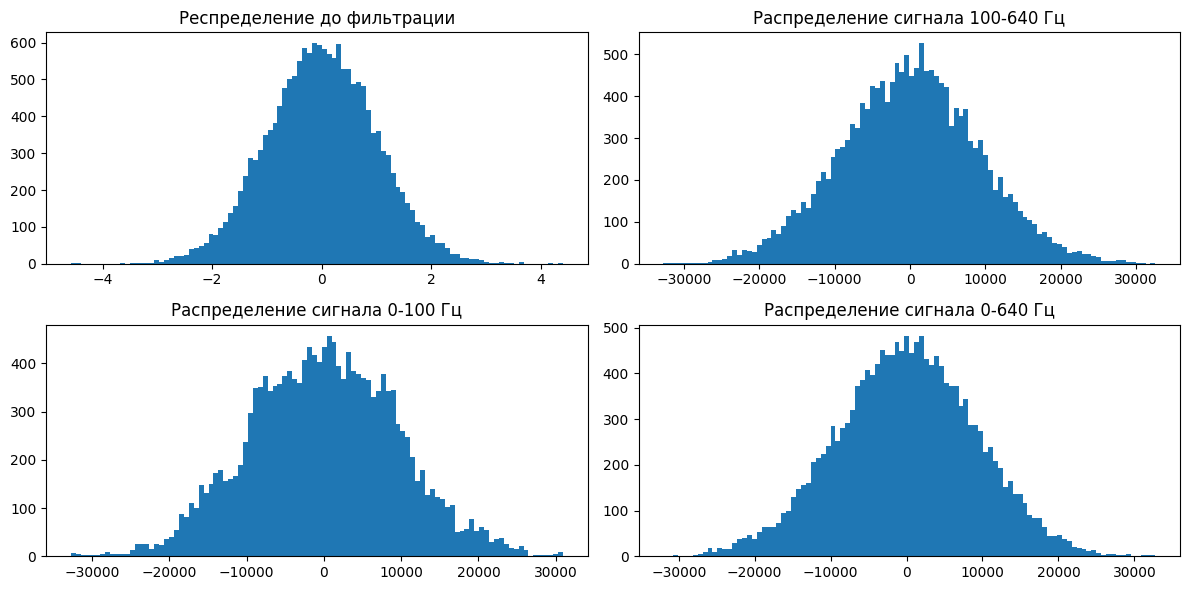

In [6]:
def plot_hist_to_ax(ax, signal, title):
    ax.hist(signal, bins=100)
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(6*2, 3*2))
plot_hist_to_ax(axes[0][0], white_normal, 'Респределение до фильтрации')
plot_hist_to_ax(axes[0][1], noise_100_640_16bit, 'Распределение сигнала 100-640 Гц')
plot_hist_to_ax(axes[1][0], noise_0_100_16bit, 'Распределение сигнала 0-100 Гц')
plot_hist_to_ax(axes[1][1], noise_0_640_16bit, 'Распределение сигнала 0-640 Гц')

plt.tight_layout()
plt.show()

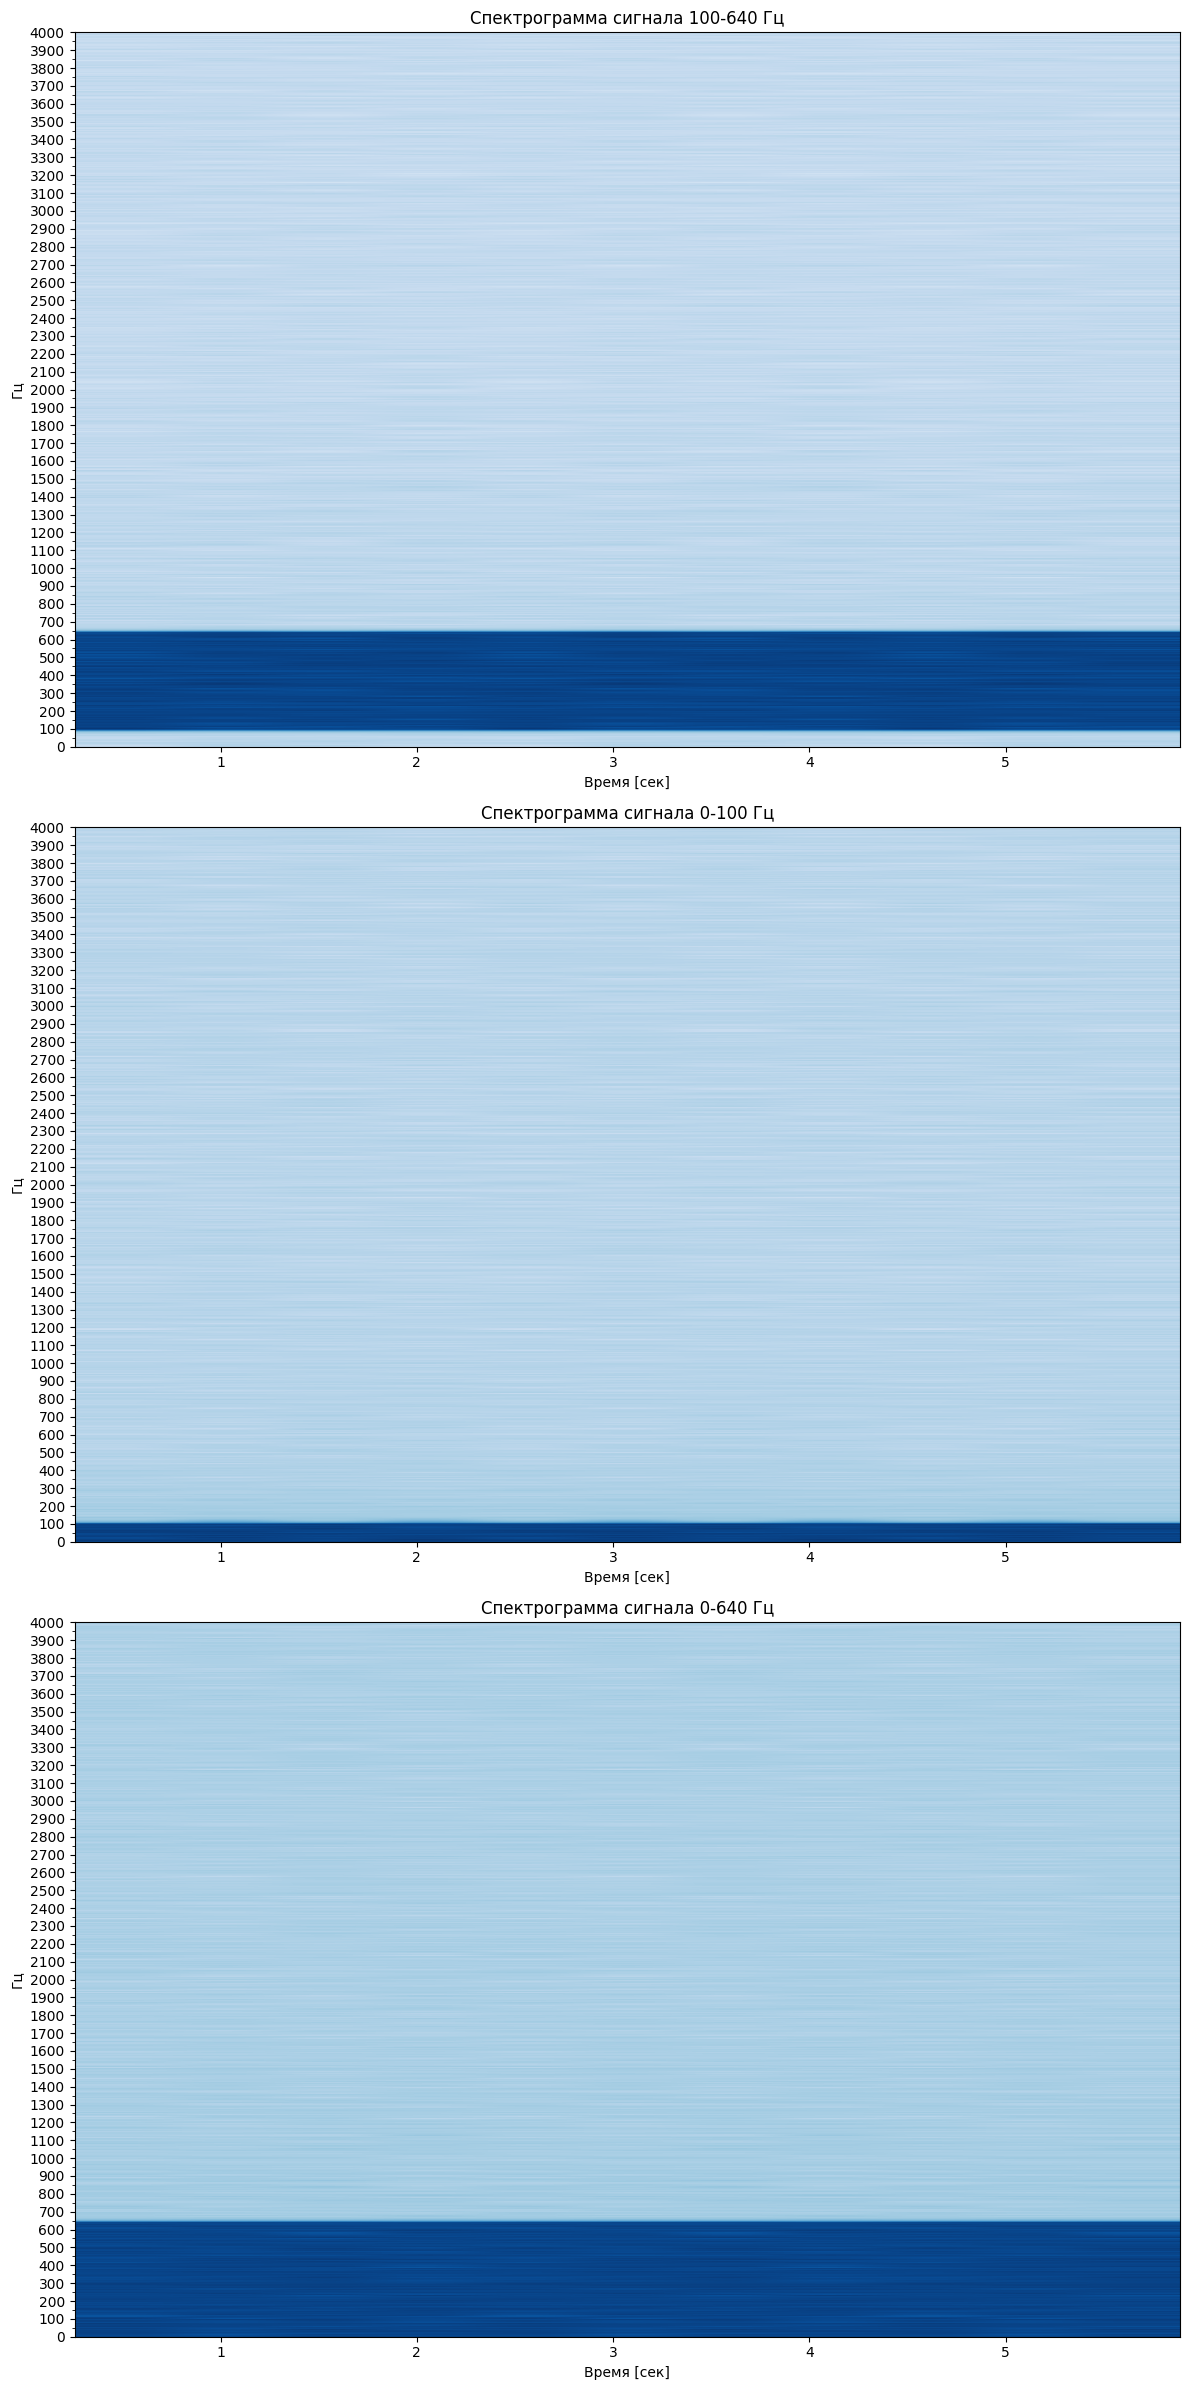

In [7]:
def plot_spectrogram_to_ax(ax, loop_signal, title, sample_rate=8000, NFFT=8192, noverlap=4096, cmap='Blues'):
    signal = np.concatenate([loop_signal, loop_signal, loop_signal])
    ax.specgram(signal, NFFT=NFFT, Fs=sample_rate, noverlap=noverlap, cmap=cmap)
    ax.set_xlabel('Время [сек]')
    ax.set_ylabel('Гц')
    ax.set_ylim(0, sample_rate / 2)
    ax.major_locator = ticker.MultipleLocator(base=100)
    ax.yaxis.set_major_locator(ax.major_locator)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=50)) 
    ax.set_title(title)

fig, axes = plt.subplots(3, 1, figsize=(12, 8*3))
plot_spectrogram_to_ax(axes[0], noise_100_640_16bit, 'Спектрограмма сигнала 100-640 Гц')
plot_spectrogram_to_ax(axes[1], noise_0_100_16bit, 'Спектрограмма сигнала 0-100 Гц')
plot_spectrogram_to_ax(axes[2], noise_0_640_16bit, 'Спектрограмма сигнала 0-640 Гц')

plt.tight_layout()
plt.show()

In [ ]:
save_wav(noise_100_640_16bit, 'noise_100_640_8000Hz_16bit.wav')
save_wav(noise_0_640_16bit,   'noise_0_640_8000Hz_16bit.wav')
save_wav(noise_0_100_16bit,   'noise_0_100_8000Hz_16bit.wav')

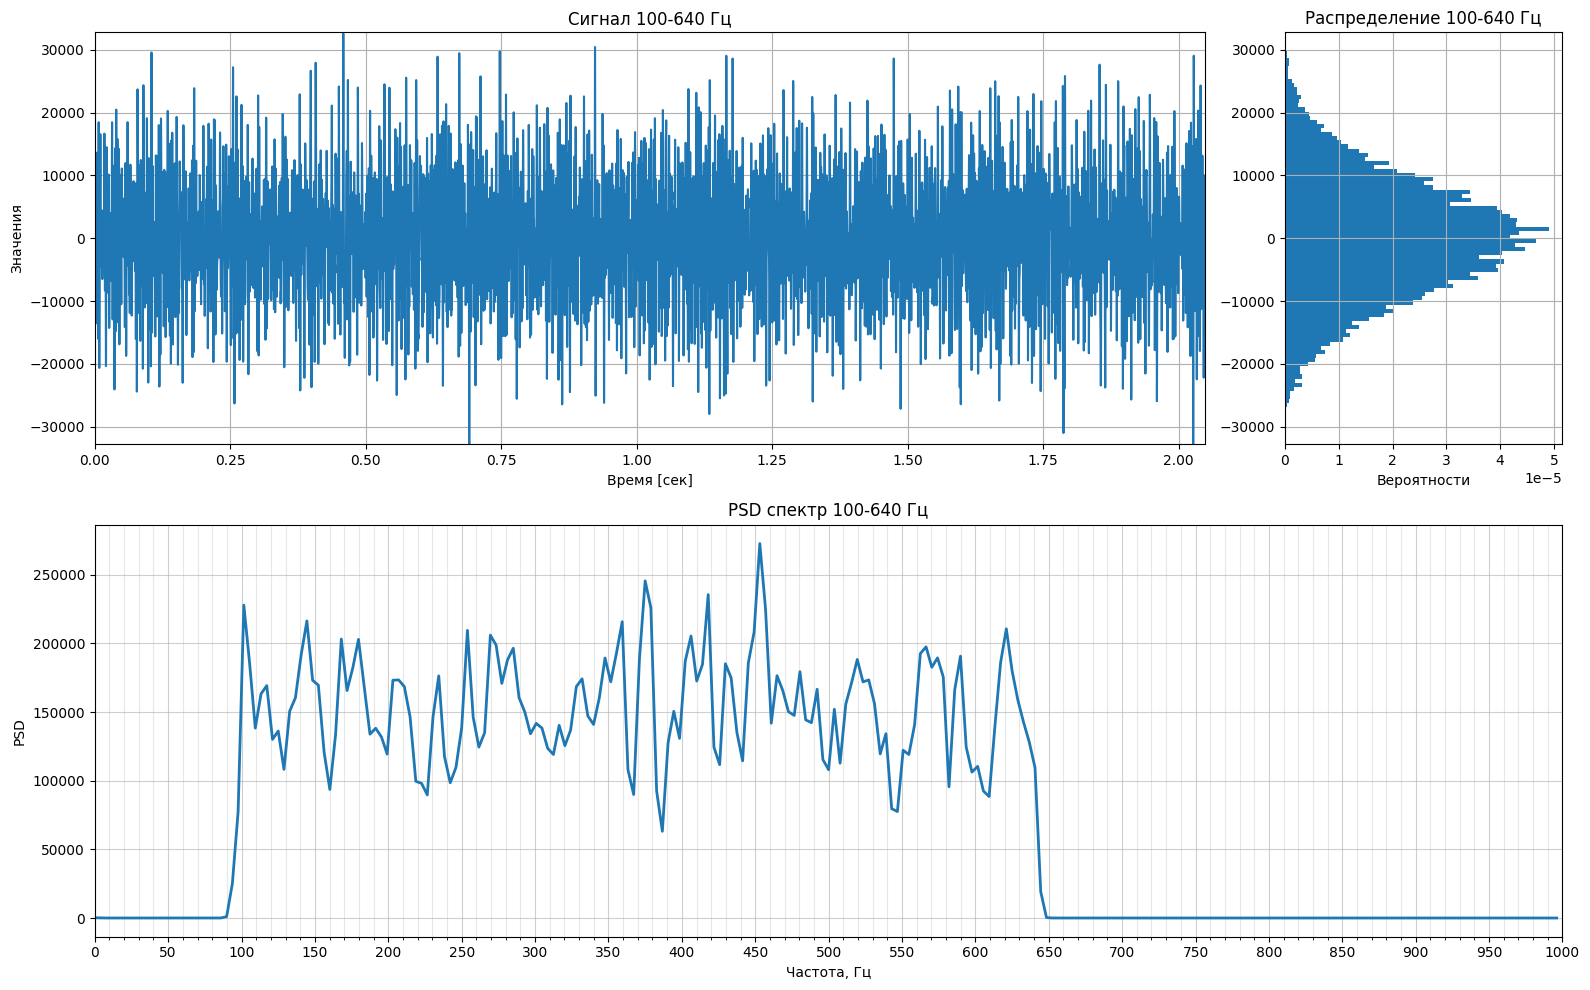

In [8]:
from scipy.signal import welch

def plot_hist_to_ax(ax, signal, title):
    ax.hist(signal, bins=100, density=True, orientation='horizontal')
    ax.set_title(title)
    ax.set_ylim(-32768, 32767)  # По Y - значения сигнала
    # ax.set_ylabel('Значения')
    ax.set_xlabel('Вероятности')
    ax.grid()

def plot_osc_to_ax(ax, signal, title, sample_rate=8000):
    ax.plot(np.linspace(0, duration, len(signal), endpoint=False), signal)
    ax.set_xlabel('Время [сек]')
    ax.set_ylabel('Значения')
    ax.set_ylim(-32768, 32767)
    ax.set_xlim(0, duration)
    ax.set_title(title)
    ax.grid()


def plot_psd_to_ax(ax, signal, title, max_freq=None, sample_rate=8000):    
    frequencies, psd = welch(signal, fs=sample_rate, nperseg=2048, noverlap=2047)
    if not max_freq:
        max_freq = sample_rate / 2
    ind = frequencies < max_freq
    ax.plot(frequencies[ind], psd[ind], linewidth=2)
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('PSD')
    ax.set_xlim(0, max_freq)
    ax.set_title(title)
    # Подробные тики: major каждые 50 Гц, minor каждые 10 Гц
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=10))
    ax.grid(which='major', alpha=0.6)
    ax.grid(which='minor', alpha=0.3)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[4, 1]) 

ax_osc = fig.add_subplot(gs[0, 0])
ax_hist = fig.add_subplot(gs[0, 1])
ax_spec = fig.add_subplot(gs[1, :])  # Занимает обе колонки

plot_osc_to_ax(ax_osc, noise_100_640_16bit, 'Сигнал 100-640 Гц')
plot_hist_to_ax(ax_hist, noise_100_640_16bit, 'Распределение 100-640 Гц')
plot_psd_to_ax(ax_spec, noise_100_640_16bit, 'PSD спектр 100-640 Гц', max_freq=1000)

plt.tight_layout()
plt.show()

In [ ]:
import base64
import struct

samples = noise_100_640_16bit
data = struct.pack('<' + 'h' * len(samples), *samples)
b64 = base64.b64encode(data).decode()

# Разбиваем на строки по 100 символов
lines = [b64[i:i+100] for i in range(0, len(b64), 100)]

print('const char PRESET_B64[] PROGMEM =')
for line in lines:
    print(f'  "{line}"')
print(';')

In [12]:
np.mean(noise_100_640_16bit), np.std(noise_100_640_16bit), np.max(np.abs(noise_100_640_16bit))

(np.float64(-0.00177001953125), np.float64(9187.274888939897), np.int16(32767))